# Loading Libraries and Setting Up Describe Function

In [69]:
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, _fit_transform_one, _transform_one
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin
from sklearn.externals.joblib import Parallel, delayed
from sklearn.metrics import  roc_auc_score
from scipy import sparse
from matplotlib import pyplot as plt
import numpy as np
import xgboost
import gc
from hyperopt import fmin, tpe, hp,STATUS_OK
from IPython.core.display import display, HTML

#display(HTML("<style>.container { width:85% !important; }</style>"))
pd.options.display.float_format = '{:.2f}'.format

#os.chdir(r'C:\Users\naimesh.chaudhari\Downloads')



def describe(df):
    ds = df.describe(include = 'all').transpose().sort_values(by = 'mean', ascending = False)
    totalUniques = pd.DataFrame(df.nunique(), columns = ['Uniques'])
    totalUniques['dtypes'] = df.dtypes
    totalUniques['Nans'] =  df.isna().sum()
    ds = ds.merge(totalUniques,left_index = True,right_index=True)
    ds.drop('unique', inplace = True, axis = 1)
    ds['NanPercent'] = ds['Nans']/ds['count']
    return ds


#ds = describe(df)

#  Train Datset

## Loading Train Dataset

In [70]:
train = pd.read_csv('application_train.csv')
Y = train['TARGET']
train.drop('TARGET', inplace  = True, axis = 1)

## Train Feature Engineering & Split into [train, valid, test]

In [72]:
train[train.columns[train.columns.str.contains('DAYS')]] = abs(train[train.columns[train.columns.str.contains('DAYS')]]).replace(365243, np.nan)/365 

train['DAYS_EMPLOYED_PERC'] = (train.DAYS_EMPLOYED / train.DAYS_BIRTH).replace(np.inf, 0)
train['INCOME_CREDIT_PERC'] = (train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']).replace(np.inf, 0)
train['INCOME_PER_PERSON'] = (train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']).replace(np.inf, 0)
train['ANNUITY_INCOME_PERC'] =( train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']).replace(np.inf, 0)

X_train,X_valid,y_train,y_valid = train_test_split(train,Y, test_size = .10, stratify = Y )
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = .10, stratify = y_train )

## Transforming Train Data On Selected Features

In [73]:
num_attribs = [
     'SK_ID_CURR' 
    ,'AMT_INCOME_TOTAL'
    ,'AMT_CREDIT'
    ,'DAYS_EMPLOYED'
    ,'DAYS_BIRTH'
    ,'EXT_SOURCE_1'
    ,'EXT_SOURCE_2'
    ,'EXT_SOURCE_3'
    ,'AMT_ANNUITY'
    ,'DAYS_EMPLOYED_PERC'
    ,'INCOME_CREDIT_PERC'
    ,'INCOME_PER_PERSON'
    ,'ANNUITY_INCOME_PERC'
]

cat_attribs = [
    'CODE_GENDER'
    ,'FLAG_OWN_REALTY'
    ,'FLAG_OWN_CAR'
    ,'NAME_CONTRACT_TYPE' 
    ,'NAME_EDUCATION_TYPE'
    ,'OCCUPATION_TYPE'
    ,'NAME_INCOME_TYPE'

]


                    
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat',cat_pipeline,cat_attribs),
   ])

#Fitting and Tranforming Train
X_train = pd.DataFrame(full_pipeline.fit_transform(X_train))
allcols = num_attribs + list(full_pipeline.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_attribs))
X_train.columns  = allcols

#Transforming Valid
X_valid = pd.DataFrame(full_pipeline.transform(X_valid))
X_valid.columns  = allcols

#Transforming test
X_test = pd.DataFrame(full_pipeline.transform(X_test))
X_test.columns  = allcols

#Setting Indexes and dropping COlumns
X_train.index = X_train['SK_ID_CURR']
X_train.drop('SK_ID_CURR', inplace = True, axis = 1)
X_valid.index = X_valid['SK_ID_CURR']
X_valid.drop('SK_ID_CURR', inplace = True, axis = 1)
X_test.index = X_test['SK_ID_CURR']
X_test.drop('SK_ID_CURR', inplace = True, axis = 1)

# Testing Train Datset With XGBOOST

In [74]:
params = {
    'n_estimators'  : 5000,
    'booter' : 'gbtree',
    'objective' : 'binary:logistic',
    'tree_method' : 'hist',
    'learning_rate' : 0.1,
    'max_depth': 4,
    'colsample_bytree' : 0.8,
    'subsample' :0.8,
    'n_jobs': -1,
    'gamma' : 0.33,
    'reg_alpha' : 0.04,
    'reg_lambda' : 0.08
    }

mdl = xgboost.XGBClassifier(**params)
mdl.fit(X_train,y_train,
        eval_set = [(X_valid,y_valid)],
        eval_metric=['auc','logloss']
        ,early_stopping_rounds=100
        ,verbose = True)


[0]	validation_0-auc:0.698322	validation_0-logloss:0.624856
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-auc:0.704947	validation_0-logloss:0.569148
[2]	validation_0-auc:0.714345	validation_0-logloss:0.523176
[3]	validation_0-auc:0.715268	validation_0-logloss:0.484759
[4]	validation_0-auc:0.716008	validation_0-logloss:0.452389
[5]	validation_0-auc:0.718621	validation_0-logloss:0.424553
[6]	validation_0-auc:0.721809	validation_0-logloss:0.4011
[7]	validation_0-auc:0.721554	validation_0-logloss:0.380819
[8]	validation_0-auc:0.722537	validation_0-logloss:0.363669
[9]	validation_0-auc:0.721785	validation_0-logloss:0.348953
[10]	validation_0-auc:0.72439	validation_0-logloss:0.336559
[11]	validation_0-auc:0.725087	validation_0-logloss:0.325333
[12]	validation_0-auc:0.726006	validation_0-logloss:0.315819
[13]	validation_0-auc:0.726654	validation_0-logloss:0.

[132]	validation_0-auc:0.74726	validation_0-logloss:0.249185
[133]	validation_0-auc:0.747288	validation_0-logloss:0.249177
[134]	validation_0-auc:0.747358	validation_0-logloss:0.249152
[135]	validation_0-auc:0.747414	validation_0-logloss:0.249136
[136]	validation_0-auc:0.74766	validation_0-logloss:0.249059
[137]	validation_0-auc:0.747636	validation_0-logloss:0.249066
[138]	validation_0-auc:0.747712	validation_0-logloss:0.249047
[139]	validation_0-auc:0.747705	validation_0-logloss:0.249044
[140]	validation_0-auc:0.747826	validation_0-logloss:0.249016
[141]	validation_0-auc:0.747842	validation_0-logloss:0.249011
[142]	validation_0-auc:0.747916	validation_0-logloss:0.248994
[143]	validation_0-auc:0.747986	validation_0-logloss:0.248975
[144]	validation_0-auc:0.747984	validation_0-logloss:0.248977
[145]	validation_0-auc:0.74801	validation_0-logloss:0.248955
[146]	validation_0-auc:0.748116	validation_0-logloss:0.248927
[147]	validation_0-auc:0.748182	validation_0-logloss:0.248909
[148]	valid

[265]	validation_0-auc:0.749584	validation_0-logloss:0.248533
[266]	validation_0-auc:0.749644	validation_0-logloss:0.248522
[267]	validation_0-auc:0.74959	validation_0-logloss:0.248531
[268]	validation_0-auc:0.749544	validation_0-logloss:0.248541
[269]	validation_0-auc:0.749541	validation_0-logloss:0.248529
[270]	validation_0-auc:0.74956	validation_0-logloss:0.248522
[271]	validation_0-auc:0.74961	validation_0-logloss:0.24851
[272]	validation_0-auc:0.749683	validation_0-logloss:0.248489
[273]	validation_0-auc:0.749663	validation_0-logloss:0.248496
[274]	validation_0-auc:0.749673	validation_0-logloss:0.248497
[275]	validation_0-auc:0.749718	validation_0-logloss:0.248481
[276]	validation_0-auc:0.749735	validation_0-logloss:0.248474
[277]	validation_0-auc:0.749668	validation_0-logloss:0.248484
[278]	validation_0-auc:0.749718	validation_0-logloss:0.248466
[279]	validation_0-auc:0.749671	validation_0-logloss:0.248479
[280]	validation_0-auc:0.749622	validation_0-logloss:0.248487
[281]	valida

XGBClassifier(base_score=0.5, booster='gbtree', booter='gbtree',
       colsample_bylevel=1, colsample_bytree=0.8, gamma=0.33,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.04, reg_lambda=0.08, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, tree_method='hist')

In [89]:
scores = mdl.predict_proba(X_test)[:,1]
roc_auc_score(y_test, scores)

0.7474452309840622

## Checking to Find Important Features

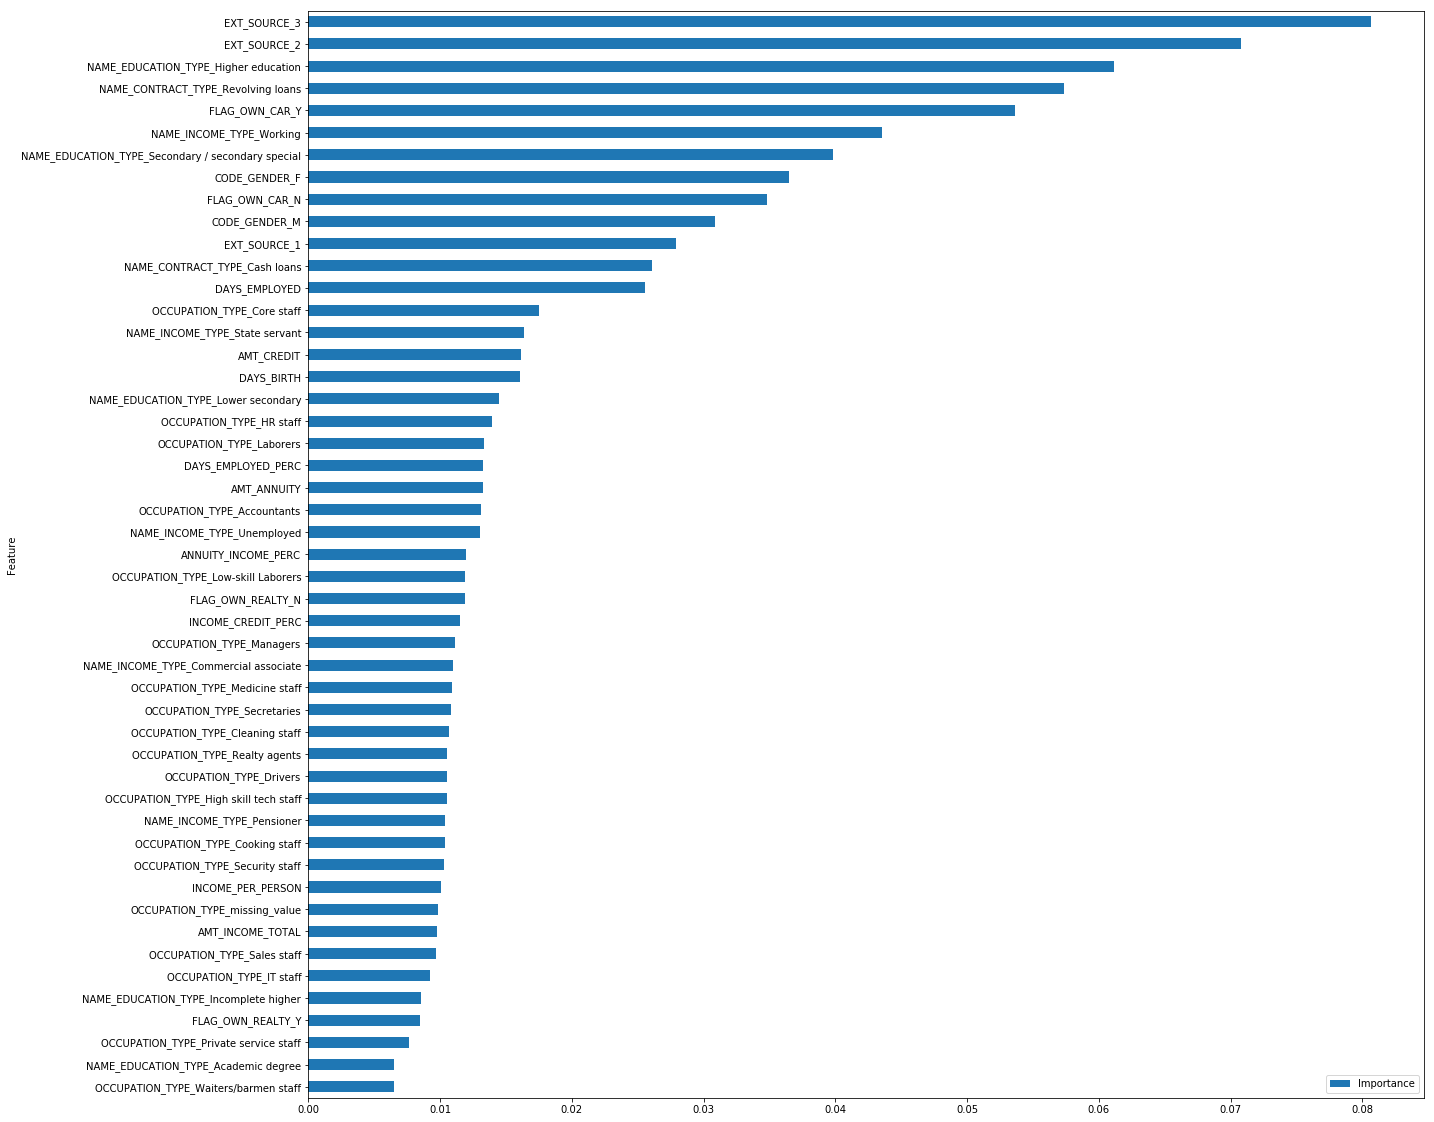

In [90]:
fitted_models = {}
fitted_models['train'] = mdl

imp = pd.DataFrame(fitted_models['train'].feature_importances_, columns = ['Importance'])
imp['Feature'] = X_train.columns
imp[imp.Importance > 0.005].sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', x = 'Feature', figsize = (20,20))

# Adding Previous Application File To the Dataset

## Function To Load and aggeregate previous application

In [91]:
def pa():
    df  = pd.read_csv('previous_application.csv')

    df[df.columns[df.columns.str.contains('DAYS')]] = abs(df[df.columns[df.columns.str.contains('DAYS')]]).replace(365243, np.nan)/365  #converting days to years and removing outliers
    df['AppToCredit'] =  (df.AMT_APPLICATION/df.AMT_CREDIT).replace(np.inf, 0)
    df['DownToCredit'] = (df.AMT_DOWN_PAYMENT/df.AMT_CREDIT).replace(np.inf, 0)


    catattri = [
        'NAME_CLIENT_TYPE'
        ,'NAME_CONTRACT_STATUS'
        ,'NAME_YIELD_GROUP'
        ,'WEEKDAY_APPR_PROCESS_START'
        ,'NFLAG_INSURED_ON_APPROVAL'
        ,'CHANNEL_TYPE'
        ,'PRODUCT_COMBINATION'
    ]

    numattri = [
        'SK_ID_CURR'
        ,'SK_ID_PREV'
        ,'DAYS_FIRST_DRAWING'
        ,'DAYS_DECISION'
        ,'DAYS_LAST_DUE'
        ,'DAYS_FIRST_DUE'
        ,'CNT_PAYMENT'
        ,'HOUR_APPR_PROCESS_START'
        ,'AMT_ANNUITY'
        ,'AMT_APPLICATION'
        ,'AMT_DOWN_PAYMENT'
        ,'AppToCredit'
        ,'SELLERPLACE_AREA'
    ]


    df[catattri] = df[catattri].astype('str')
    df[numattri] = df[numattri].astype('float32')

    npipe  = Pipeline([
        ('imuter', SimpleImputer(strategy = 'mean'))
                     ])
    
    cpipe = Pipeline ([
        ('imputer', SimpleImputer(strategy = 'constant')),
        ('encode', OneHotEncoder())
                    ])



    ct = ColumnTransformer([
        ("num", npipe, numattri),
        ("norm2", cpipe, catattri)
    ])



    df = pd.DataFrame(ct.fit_transform(df))
    allcols = numattri + list(ct.named_transformers_['norm2'].named_steps['encode'].get_feature_names(catattri))
    df.columns = allcols
    df.drop('SK_ID_PREV', inplace  = True, axis  = 1)
    df = df.groupby('SK_ID_CURR').agg([np.mean,'count',sum])
    df.columns =  ['_'.join(col).strip() for col in df.columns.values]
    pa_app = df.add_prefix('PA_')


    del df, allcols,npipe,cpipe,ct,numattri,catattri,
    gc.collect()

    return pa_app


## Loading Previous Application File and Merging it with Train 

In [92]:
pa_app = pa()

X_train_pa = X_train.merge(pa_app, on = 'SK_ID_CURR', how = 'left')
X_valid_pa = X_valid.merge(pa_app, on = 'SK_ID_CURR', how = 'left')
X_test_pa = X_test.merge(pa_app, on = 'SK_ID_CURR', how = 'left')

X_train_pa.fillna(0, inplace= True)
X_valid_pa.fillna(0, inplace= True)
X_test_pa.fillna(0, inplace= True)

## Finding Optimal Parameters

In [128]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'learning_rate' : '{:.3f}'.format(params['learning_rate']),
        'min_child_weight' : int(params['min_child_weight']),
        'subsample' : '{:.3f}'.format(params['subsample']),
        'objective': 'binary:logistic',
        'booster': 'gbtree'      
           }
    

    
    clf = xgboost.XGBClassifier(
        n_estimators=500,
        n_jobs=-1,
        **params
    )
    
    gbm_model = clf.fit(X_train_pa , y_train
                ,eval_set=[(X_valid_pa, y_valid)]
                ,eval_metric=['logloss','auc']
                ,early_stopping_rounds = 30
                ,verbose=False)
    
    predictions = gbm_model.predict_proba(X_valid_pa)[:, 1]
    score = roc_auc_score(y_valid, predictions)
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': 1-score, 'status': STATUS_OK}

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0,0.1),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
     'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.0, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0.0, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0.0, 1, 0.1),
    
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)
print(best)

	Score 0.7586459337410697                            


	Score 0.7600861563467264                                                       


	Score 0.7614377362798432                                                        


	Score 0.760046636132386                                                         


	Score 0.7607544881906434                                                        


	Score 0.7597202951843735                                                         


	Score 0.7591304054097276                                                         


	Score 0.7605180507439266                                                         


	Score 0.7606308628626195                                                         


	Score 0.7594844560970665                                                         


	Score 0.7583090217768205                                                         


	Score 0.7597226601287068                                                         


	Score 0.75995

	Score 0.7616278151189666                                                          


	Score 0.7583780040687587                                                          


	Score 0.7603688740444469                                                          


	Score 0.7617156386089814                                                          


	Score 0.7605319554768741                                                          


	Score 0.7604545320432649                                                          


100%|██████████| 100/100 [3:36:01<00:00, 166.84s/it, best loss: 0.23814277815737994]
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.025, 'max_depth': 8.0, 'min_child_weight': 4.0, 'reg_alpha': 0.4, 'reg_lambda': 0.9, 'subsample': 0.55}


## Training Model on Optimal Parameters

In [129]:
params = {
    'n_estimators'  : 5000,
    'booter' : 'gbtree',
    'objective' : 'binary:logistic',
    'tree_method' : 'hist',
    'learning_rate' : 0.025,
    'max_depth': 8,
    'min_child_weight' :  4.0,
    'colsample_bytree' : 0.8, #o,30?
    'subsample' :0.55,
    'n_jobs': -1,
    'gamma' : 0.1,
    'reg_alpha' : 0.4,
    'reg_lambda' : 0.9
    }

mdl = xgboost.XGBClassifier(**params)
mdl.fit(X_train_pa,y_train,
        eval_set = [(X_valid_pa,y_valid)],
        eval_metric=['logloss','auc']
        ,early_stopping_rounds=200
        ,verbose = True)


In [95]:
scores_pa = mdl.predict_proba(X_test_pa)[:,1]
roc_auc_score(y_test, scores_pa)

0.7616771205762511

## Checking Feature Importance

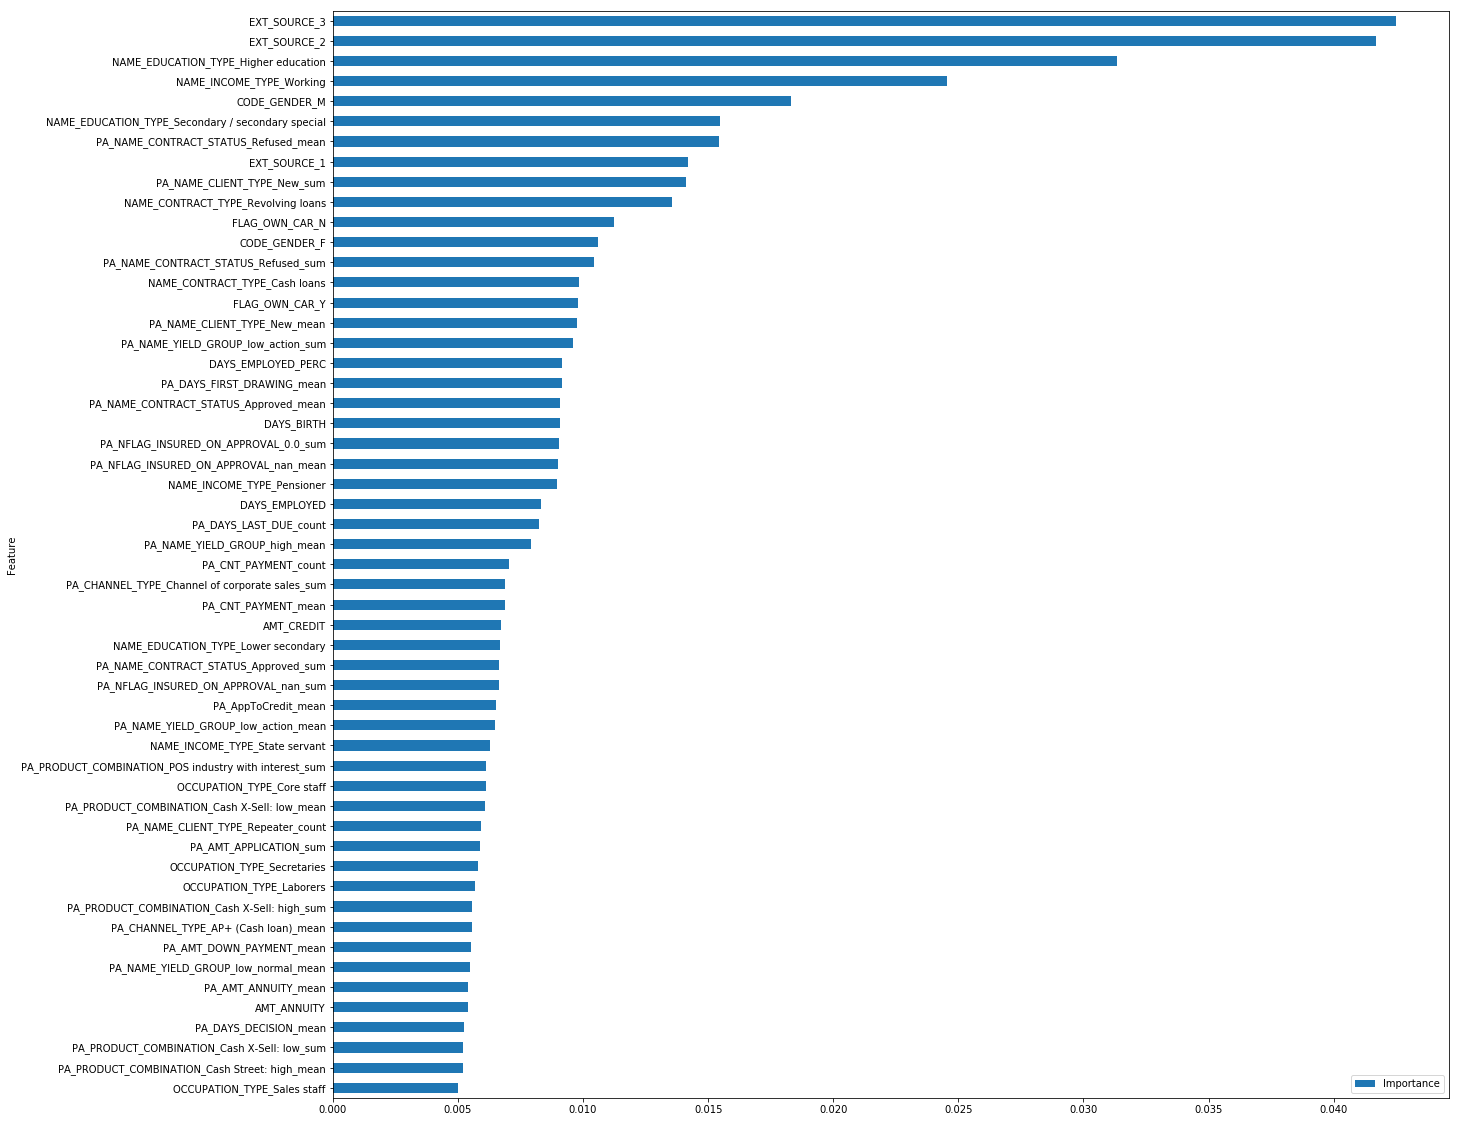

In [96]:
fitted_models['train_w_pvapp'] = mdl
imp_pa = pd.DataFrame(mdl.feature_importances_, columns = ['Importance'])
imp_pa['Feature'] = X_train_pa.columns
imp_pa[imp_pa.Importance > 0.005].sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', x = 'Feature', figsize=(20,20))

## Selecting Optimal Number of features to take forwad

### Best set of Scores came with 100 features 

In [130]:
# imp_pa = imp_pa.sort_values(by = 'Importance', ascending = False)
scores = []
numfeatures = []
for x  in range(1,25):
    x  = x * 10
    features = imp_pa['Feature'][0:x].values
    train  = X_train_pa[features]
    valid = X_valid_pa[features]
    test = X_test_pa[features]
    mdl.fit(train,y_train,
        eval_set = [(valid,y_valid)],
        eval_metric=['logloss','auc']
        ,early_stopping_rounds=150
        ,verbose = False)
    scores.append(mdl.best_score)
    iteration.append(x)
    scores_pa = mdl.predict_proba(test)[:,1]
    roc = roc_auc_score(y_test, scores_pa)
    print('Best score for valid is ' + str(round(mdl.best_score,4)) + ' on top ' + str(x) + ' features by importance')
    print('Best score for test is ' + str(round(roc,4)) + ' on top ' + str(x) + ' features by importance\n')
    

Best score for valid is 0.7345 on top 10 features by importance
Best score for train is 0.7308 on top 10 features by importance

Best score for valid is 0.7441 on top 20 features by importance
Best score for train is 0.7384 on top 20 features by importance

Best score for valid is 0.7536 on top 30 features by importance
Best score for train is 0.7527 on top 30 features by importance

Best score for valid is 0.7591 on top 40 features by importance
Best score for train is 0.7576 on top 40 features by importance

Best score for valid is 0.7603 on top 50 features by importance
Best score for train is 0.7617 on top 50 features by importance

Best score for valid is 0.7607 on top 60 features by importance
Best score for train is 0.7622 on top 60 features by importance

Best score for valid is 0.7611 on top 70 features by importance
Best score for train is 0.7603 on top 70 features by importance

Best score for valid is 0.7599 on top 80 features by importance
Best score for train is 0.7609 on

## Testing Optimal Set of Parameters BY PCA

### PCA performerd poorly vs using the importance from xgboost models at 100 features

In [131]:
from sklearn.decomposition import PCA
for x  in range(1,18):
    x  = x * 10
    pc  = PCA(n_components  = x)
    X_train_pa_pc = pc.fit_transform(X_train_pa)
    X_valid_pa_pc = pc.transform(X_valid_pa)
    X_test_pa_pc = pc.transform(X_test_pa)

    mdl.fit(X_train_pa_pc,y_train,
        eval_set = [(X_valid_pa_pc,y_valid)],
        eval_metric=['logloss','auc']
        ,early_stopping_rounds=100
        ,verbose = False)

    scores_pc = mdl.predict_proba(X_test_pa_pc)[:,1]
    roc = roc_auc_score(y_test, scores_pc)

    print('Best score for valid is ' + str(round(mdl.best_score,4)) + ' on top ' + str(x) + ' features by importance')
    print('Best score for train is ' + str(round(roc,4)) + ' on top ' + str(x) + ' features by importance\n')
    


Best score for valid is 0.6109 on top 10 features by importance
Best score for train is 0.6122 on top 10 features by importance

Best score for valid is 0.659 on top 20 features by importance
Best score for train is 0.6623 on top 20 features by importance

Best score for valid is 0.6754 on top 30 features by importance
Best score for train is 0.68 on top 30 features by importance

Best score for valid is 0.6781 on top 40 features by importance
Best score for train is 0.6862 on top 40 features by importance

Best score for valid is 0.6949 on top 50 features by importance
Best score for train is 0.7034 on top 50 features by importance

Best score for valid is 0.7049 on top 60 features by importance
Best score for train is 0.7055 on top 60 features by importance

Best score for valid is 0.7062 on top 70 features by importance
Best score for train is 0.7048 on top 70 features by importance

Best score for valid is 0.7118 on top 80 features by importance
Best score for train is 0.7075 on to

In [115]:
fitted_models = {}
features = imp_pa['Feature'][0:100].values
train  = X_train_pa[features]
valid = X_valid_pa[features]
test = X_test_pa[features]
mdl.fit(train,y_train,
    eval_set = [(valid,y_valid)],
    eval_metric=['logloss','auc']
    ,early_stopping_rounds=100
    ,verbose = False)

fitted_models['final'] = mdl

# Submitting test File

In [123]:
def test_sub(full_pipeline,df_pv_app,fitted_models,features,key=""):
    df_test = pd.read_csv('application_test.csv')
    df_test.index = df_test['SK_ID_CURR']
    df_test[df_test.columns[df_test.columns.str.contains('DAYS')]] = abs(df_test[df_test.columns[df_test.columns.str.contains('DAYS')]]).replace(365243, np.nan)/365 
    df_test['DAYS_EMPLOYED_PERC'] = (df_test.DAYS_EMPLOYED / df_test.DAYS_BIRTH).replace(np.inf, 0)
    df_test['INCOME_CREDIT_PERC'] = (df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']).replace(np.inf, 0)
    df_test['INCOME_PER_PERSON'] = (df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']).replace(np.inf, 0)
    df_test['ANNUITY_INCOME_PERC'] =( df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']).replace(np.inf, 0)
    
    num_attribs = [
         'SK_ID_CURR' 
        ,'AMT_INCOME_TOTAL'
        ,'AMT_CREDIT'
        ,'DAYS_EMPLOYED'
        ,'DAYS_BIRTH'
        ,'EXT_SOURCE_1'
        ,'EXT_SOURCE_2'
        ,'EXT_SOURCE_3'
        ,'AMT_ANNUITY'
        ,'DAYS_EMPLOYED_PERC'
        ,'INCOME_CREDIT_PERC'
        ,'INCOME_PER_PERSON'
        ,'ANNUITY_INCOME_PERC'
    ]

    cat_attribs = [
        'CODE_GENDER'
        ,'FLAG_OWN_REALTY'
        ,'FLAG_OWN_CAR'
        ,'NAME_CONTRACT_TYPE' 
        ,'NAME_EDUCATION_TYPE'
        ,'OCCUPATION_TYPE'
        ,'NAME_INCOME_TYPE'

    ]

    
    
    tst_ind = df_test['SK_ID_CURR']
    test = pd.DataFrame(full_pipeline.transform(df_test), index = tst_ind)
    allcols = num_attribs + list(full_pipeline.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_attribs))
    test.columns  = allcols
    test.drop('SK_ID_CURR', inplace = True, axis = 1)

    
    test = test.merge(df_pv_app, how = 'left', on = 'SK_ID_CURR')    
    test.fillna(0,inplace = True)
    
    test  = test[features]
    pred = fitted_models[key].predict_proba(test)[:,1]
    sub = pd.DataFrame(tst_ind)
    sub['TARGET'] = pred
    sub.to_csv('submission.csv', index = False)


In [124]:
test_sub(full_pipeline,pa_app,fitted_models,features,key  = "final" )

In [125]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "XGBoost - Hist - TunedHP - 100 Important features with previous app"


Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/925k [00:00<?, ?B/s]
  1%|          | 8.00k/925k [00:00<00:13, 71.3kB/s]
 95%|#########5| 880k/925k [00:00<00:00, 101kB/s]  
100%|##########| 925k/925k [00:03<00:00, 245kB/s]


In [126]:
!kaggle competitions submissions home-credit-default-risk

fileName           date                 description                                                                    status    publicScore  privateScore  
-----------------  -------------------  -----------------------------------------------------------------------------  --------  -----------  ------------  
submission.csv     2019-04-16 05:17:15  XGBoost - Hist - TunedHP - 100 Important features with previous app            complete  0.75034      0.75570       
submission.csv     2019-04-13 15:15:13  XGBoost - Hist - TunedHP                                                       complete  0.74813      0.75039       
submission.csv     2019-04-07 19:47:17  XGBoost - Hist - TunedHP                                                       complete  0.75162      0.75435       
submission.csv     2019-04-07 06:05:35  LightGBM - TunedHP                                                             complete  0.74094      0.74544       
submission.csv     2019-04-07 05:30:19  XGBoost - Hist - T